In [1]:
%matplotlib inline

import numpy as np

from pytriqs.plot.mpl_interface import plt

In [2]:
plt.style.use('./notebook.mplstyle')

# Using the (semi) particle-hole transformation on the Hubbard model on a square lattice

## Hubbard model on a square lattice

The Hamiltonian of the Hubbard model on a square lattice is given by

$$
H=-t \sum_{\langle j, 1\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{1 \sigma}+c_{1 \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j} n_{j \uparrow} n_{j \downarrow}-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)\,.
$$

The first term describes the kinetic energy in terms of hopping processes between adjoining lattice sites, indicated by the angular brakets.
The second term desribes the onsite interaction.
The third term determines the filling via the chemical potential.

Here $c_{j\sigma}^{\dagger}$ creates an electron on site $j$ with spin $\sigma$ while $c_{j\sigma}$ destroys such an electron, further the operator $n_{j\sigma}$ count the number of electrons on site $j$ with spin $\sigma$.
The first term describes the kinetic energy of the electrons, which can be interpreted as an electron with spin $\sigma$ *hopping* from site $l$ to site $j$ and vice versa.
Here the angular braket under the sum means that we only take *hopping* terms between neighboring lattice sites into account.
This is the most basic version of the kinetic part of the Hubbard model which can, and will be, extended later.

The second term describes the repulsive interaction between the electrons.
This repulsion is crudely approximated in the Hubbard model in the sense, that electrons only *see* each other if the occupy the same lattice site.

The last term describes the filling of the lattice via an energy offset by the chemical potential $\mu$.

The Hubbard model is therefore defined by the parameters $t$, $U$ and $mu$, but we also need to know the temperature $T$ at which we shal observe the Hubbard model.
We will record these parameters using the `ParameterCollection` class in `triqs_tprf.ParameterCollection`.

In [3]:
from triqs_tprf.ParameterCollection import ParameterCollection

hubbard = ParameterCollection(   # -- Model Parameter
                                 norb=1, # Number of orbitals.
                                 t=1.0, # Hopping to nearest neighbor
                                 U=1.0, # Strength of the on-site interaction
                                 mu=0.0, # Chemical potential determining the filling.
                                 T=1000, # Temperature.
    
                                 # -- Technical parameter
                                 nk=16, # Number of points in one dimension considered in the Brillouin zone.
                                 nw=50, # Number of Matsubara points in positive dimension.
                                        )
hubbard

T = 1000
U = 1.0
mu = 0.0
nk = 16
norb = 1
nw = 50
t = 1.0

A representation of the kinetic part of the Hubbard model can be constructed using the `TBLattice` class in `triqs_tprf.tight_binding` where the hoppings are given as a dictionary with relative coordinate vectors as keys and hopping matrices as values. The unit vectors of the lattice, the position of the site local orbitals and names also needs to be setup, see below.
Here we also added the functionality for next-nearest neighbor hopping, which will be used later.

From this `TBLattice` object we can obtain the dispersion relation as a mesh over the Brillouin zone via its member function `on_mesh_brillouin_zone`.
All of this is condensed in the `get_disperion_relation` which only cares about the Hubbard model parameters.
Also lets plot the bandstructure and density of states.
There we can see, that the system has a particle hole symmetric density of states.

In [4]:
from triqs_tprf.tight_binding import TBLattice

def get_disperion_relation(p):
    """Return the disperion relation for model parameters in a ParameterCollection
    """
    
    t = -p.t * np.eye(p.norb)
    
    # next-nearest neighbour hopping only if p has `tp` attribute
    try:
        tp = -p.tp * np.eye(p.norb)
    except AttributeError:
        tp = 0 * np.eye(p.norb)
    
    H = TBLattice(
        units = [(1, 0, 0), (0, 1, 0)],
        hopping = {
            # nearest neighbour hopping
            ( 0,+1): t,
            ( 0,-1): t,
            (+1, 0): t,
            (-1, 0): t,
            
            # next-nearest neighbour hopping
            ( +1,+1): tp,
            ( -1,-1): tp,
            (+1, -1): tp,
            (-1, +1): tp,
            },
        orbital_positions = [(0,0,0)]*p.norb,
        )
    
    e_k = H.on_mesh_brillouin_zone(n_k = (p.nk, p.nk, 1))

    return e_k

e_k = get_disperion_relation(hubbard)

Starting run with 1 MPI threads at : 2019-04-29 18:54:47.073302


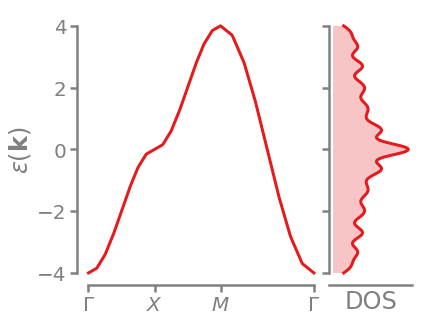

In [5]:
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from plotting_tools import bsplot

fig = plt.figure()

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
gs.update(wspace=0.025, hspace=0.05)

# -- Bandstructure
ax_bs = plt.subplot(gs[0])

lower_limit = np.min(e_k.data.real)
upper_limit = np.max(e_k.data.real)

path = 'G-X-M-G'
ax_bs.bsplot(e_k, path)

ax_bs.spines['left'].set_bounds(lower_limit, upper_limit)
ax_bs.spines['bottom'].set_bounds(ax_bs.get_xticks()[0], ax_bs.get_xticks()[-1])

ax_bs.set_ylabel('$\epsilon(\mathbf{k})$')
# -- Density of states
ax_dos = plt.subplot(gs[1])

dos = gaussian_kde(e_k.data[:,0,0].real)
xs = np.linspace(lower_limit, upper_limit , 500)
dos.covariance_factor = lambda : .1
dos._compute_covariance()

ax_dos.plot(dos(xs).real, xs)
ax_dos.fill_betweenx(xs, dos(xs).real, [0]*len(xs), alpha=0.25)
#ax_dos.set_xlim()

#ax_dos.spines['left'].set_visible(False)
ax_dos.set_xlabel('DOS')

ax_dos.set_yticklabels([''])
ax_dos.set_xticks([])

ax_dos.spines['left'].set_bounds(lower_limit, upper_limit)


## Spin and charge susceptibility

Lets first introduce some helper function to convert between temperature in Kelvin and beta in 1/eV.

In [6]:
def beta_to_temperature(beta):
    """Convert beta in 1/eV to Temperature in Kelvin
    """
    
    def eV_to_Kelvin(ev):
        return 11604.5250061657 * ev

    T = 1. / beta
    return eV_to_Kelvin(T)

def temperature_to_beta(T):
    """Convert Temperature in Kelvin to beta in 1/eV
    """
    
    def Kelvin_to_eV(K):
        return K / 11604.5250061657

    T = Kelvin_to_eV(T)
    beta = 1./ T
    return beta

We will then calculate the non-interacting susceptibiliy as previous and wrap it in a function that only cares about the Hubbard model parameters.

In [7]:
from pytriqs.gf import MeshImFreq
from triqs_tprf.lattice import lattice_dyson_g0_wk
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk


def get_chi0(p, e_k=None):
    """Return the non-interaction susceptibility for model parameters in a ParameterCollection
    """
    if not e_k:
        e_k = get_disperion_relation(p)

    wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
    g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
    
    chi0_wk = imtime_bubble_chi0_wk(g0_wk, nw=p.nw)
        
    return chi0_wk

chi0_wk = get_chi0(hubbard, e_k)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 11.6045250062
nk    = 256
nw    = 100
norb  = 1

Approx. Memory Utilization: 0.00 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


We then calculate the spin and charge susceptibiliy in the RPA limit with the know equations.

$$
EQ here lol
$$

We also wrap this is a small function that only cares about the Hubbard model parameters.

In [8]:
from triqs_tprf.rpa_tensor import kanamori_charge_and_spin_quartic_interaction_tensors
from triqs_tprf.lattice import solve_rpa_PH

def get_chiRPA(p, chi0_wk=None):
    """Return the spin and charge susceptibility in the RPA limit for model parameters in a ParameterCollection
    """
    
    if not chi0_wk:
        chi0_wk = get_chi0(p)
    
    U_c, U_s = kanamori_charge_and_spin_quartic_interaction_tensors(p.norb, p.U, 0.0, 0.0, 0.0)

    chi_c_wk = solve_rpa_PH(chi0_wk, -U_c) # Minus for correct charge rpa equation
    chi_s_wk = solve_rpa_PH(chi0_wk, U_s)
    
    return chi_c_wk, chi_s_wk

chi_c_wk, chi_s_wk = get_chiRPA(hubbard, chi0_wk)

We cann now easily acces the spin and charge susceptibility and have a look at it.
Again we see the the peak of the spin susceptibiliy at the M-point telling us, that the system will order antiferromagnetically.

Text(0.55,0.18,'$\\chi^{(c)}$')

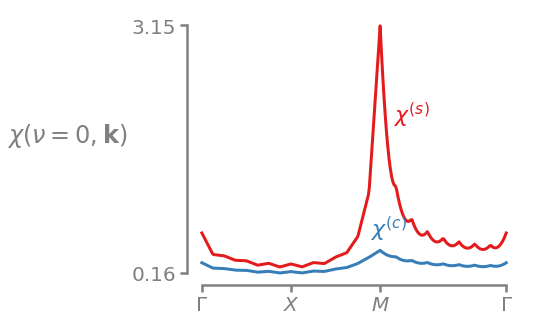

In [9]:
from pytriqs.gf import Idx

chi_c_k = chi_c_wk[Idx(0), :]
chi_s_k = chi_s_wk[Idx(0), :]

fig = plt.figure()

ax_bs = fig.add_subplot(111)

ax_bs.bsplot(chi_s_k, path)
ax_bs.bsplot(chi_c_k, path)

lower_limit = np.round(np.min(chi_c_k.data.real), 2)
upper_limit = np.round(np.max(chi_s_k.data.real), 2)

ax_bs.set_yticks([lower_limit, upper_limit])

ax_bs.spines['left'].set_bounds(lower_limit, upper_limit)
ax_bs.spines['bottom'].set_bounds(ax_bs.get_xticks()[0], ax_bs.get_xticks()[-1])

ax_bs.set_ylabel(r'$\chi(\nu=0, \mathbf{k})$', rotation=0, ha='right')
ax_bs.text(0.62, 0.6, "$\chi^{(s)}$", transform = ax_bs.transAxes, size=22, color='C0')
ax_bs.text(0.55, 0.18, "$\chi^{(c)}$", transform = ax_bs.transAxes, size=22, color='C1')

We will now introduce a small function that will find $U_\mathrm{c}$, the interaction strength at which the Hubbard model goes into a spin ordered phase.
This is done by searching for the $U$ at which 

$$
\frac{1}{\chi^{(s)}} \approx 0\,,
$$

via [`scipy.optimize.brentq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq).

In [10]:
from scipy.optimize import brentq

def get_spin_phase_transistion(p):
    """Return U at which model p transitions to spin order via root search
    """
    p = p.copy()
    
    chi0_wk = get_chi0(p)
    
    def one_over_spin(U):
        
        p.U = U
        _, chi_s_wk = get_chiRPA(p, chi0_wk)
        
        # -- If any value is below zero we are already in an ordered phase
        if np.any(chi_s_wk.data[np.abs(chi_s_wk.data) > 1e-3] < 0.0 ):
            return -1
        
        chi_at_critical_k = np.max(chi_s_wk.data)
        return 1./chi_at_critical_k
    
    U_c = brentq(one_over_spin, 0.0, 10.0)
    
    return U_c

To scan through some parameters we will copy our base model `hubbard`, which parameters are stored as a `ParameterCollection`, and only change the specific parameters.
We do this with the function `parameter_scan` which outputs us a `ParameterCollections` objects which is a container for multiple `ParameterCollection`.
We can then loop over the `ParameterCollections` object.

In [11]:
import itertools
from triqs_tprf.ParameterCollection import ParameterCollections

def parameter_scan(p, **kwargs):
    parameter_values = []

    for key, value in kwargs.iteritems():
        parameter_values.append(zip([key]*len(value), value))
    
    ps = []
    
    for parameter_value in itertools.product(*parameter_values):
        ps.append(p.copy(**dict(parameter_value)))

    return ParameterCollections(ps)

We can now do a crude scan of a $T-U$ phase diagram to map out the antiferromagnetic (AFM) phase.

In [12]:
%%capture

Ts = [1000, 750, 500, 250]
# --  Use the hubbard model as a base for the parameters and only change T
hubbard_models = parameter_scan(hubbard, T=Ts)

U_cs = []

for hubbard_model in hubbard_models:
    
    U_c = get_spin_phase_transistion(hubbard_model)   
    U_cs.append(U_c)

Text(0.625,0.3,'AFM')

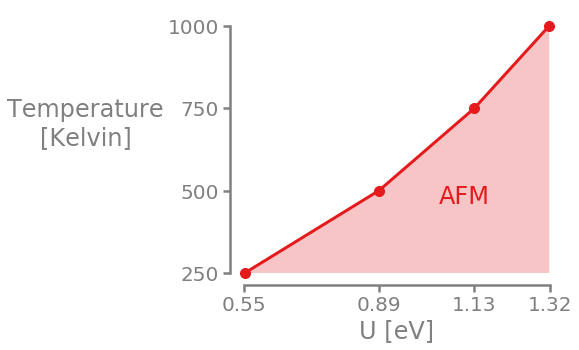

In [13]:
fig = plt.figure()

ax_pd = fig.add_subplot(111)

ax_pd.plot(U_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)

ax_pd.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd.set_xlabel('U [eV]')

ax_pd.set_yticks(Ts)
ax_pd.set_xticks([np.round(ele,2) for ele in U_cs])

ax_pd.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd.spines['bottom'].set_bounds(ax_pd.get_xticks()[0], ax_pd.get_xticks()[-1])

ax_pd.text(0.625, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')

## Particle-Hole Symmetry

The Hubbard model with only nearest neighbor hopping inhibts a useful particle-hole symmetry.
To introduce this, let us first introduce the notation of a bipartite lattice.
A bipartite lattice can be subdivided into two sublattices for which every lattice site on one of them only has neighboring sites from the other sublattice.
This is the case for our square lattice.

Let us now introduce a new kind of creation and annihilation operator

$$
d_{l \sigma}=(-1)^{l} c^\dagger_{l \sigma}\,,\quad
\mathrm{and}\quad
d_{l \sigma}^{\dagger}=(-1)^{l} c_{l \sigma}\,.\\
$$

Here $l$ is either $0$ for one sublattice and $1$ for the other.

Using this substitution is called particle-hole transformation (PHT), because the analog of the number operator for these new ones counts the number of holes, i.e.

$$
\tilde{n}_{l \sigma} = d_{l \sigma}^{\dagger} d_{l \sigma}= \underbrace{(-1)^{2l}}_{=1} c_{l \sigma}c_{l \sigma}^{\dagger} = 1-c_{l \sigma}^{\dagger} c_{l \sigma}=
1-n_{l \sigma}\,.
$$

Let us now inspect how the Hubbard Hamiltonian changes under such a PHT.
The kinetic part consists for only nearest neighbor hopping of terms of the form $c_{1 \sigma}^{\dagger} c_{j \sigma}$, where $l$ and $j$ are always from a different sublattice.
Using the PHT on it yields

$$
c_{l \sigma}^{\dagger} c_{j \sigma} \xrightarrow{\mathrm{PHT}} \underbrace{(-1)^{j+l}}_{=-1} d_{l \sigma} d_{j \sigma}^{\dagger}=
-d_{l \sigma} d_{j \sigma}^{\dagger}= d_{l \sigma}^{\dagger} d_{j \sigma}\,,
$$

showing that the kinetic part is invariant.

The interaction has terms of the form $n_{j \uparrow} n_{j \downarrow}$, using the PHT here yields

$$
n_{j \uparrow} n_{j \downarrow} =  c_{j \uparrow}^{\dagger} c_{j \uparrow} c_{j \downarrow}^{\dagger} c_{j \downarrow}
\xrightarrow{\mathrm{PHT}}
(-1)^{4j} d_{j \uparrow} d_{j \uparrow}^{\dagger} d_{j \downarrow} d_{j \downarrow}^{\dagger}=
(1- d_{j \uparrow}^{\dagger}d_{j \uparrow}) (1-d_{j \downarrow}^{\dagger}d_{j \downarrow})=\\ 
(1 - \tilde{n}_{j \uparrow}) (1 -\tilde{n}_{j \downarrow})=
1 - \tilde{n}_{j \uparrow} - \tilde{n}_{j \downarrow} + \tilde{n}_{j \uparrow}\tilde{n}_{j \downarrow}\,,
$$

which leads to additional terms.
But those terms only consist of a shift in chemical potential and an constant energy.
We can therfore write a new Hamiltonian for the Hubbard model which is also invariant in the interaction term for a PHT.

$$
H=-t \sum_{\langle j, l\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{l \sigma}+c_{l \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j}\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right)-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)
$$

Doing the PHT here yields

$$
\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right) \xrightarrow{\mathrm{PHT}}
\left(1-\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(1-\tilde{n}_{j \downarrow}-\frac{1}{2}\right) = 
\left(-\tilde{n}_{j \uparrow}+\frac{1}{2}\right)\left(-\tilde{n}_{j \downarrow}+\frac{1}{2}\right)=\\
(-1)^2 \left(\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)=
\left(\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)
$$

showing the invariance.

Using the PHT on the chemical potential term yields

$$
n_{j \uparrow}+n_{j \downarrow} \xrightarrow{\mathrm{PHT}} (1-\tilde{n}_{j \uparrow}) + (1-\tilde{n}_{j \downarrow}) = 2 - (\tilde{n}_{j \uparrow} + \tilde{n}_{j \downarrow})\,,
$$

and therefore an unimportant constant term, but also a sign change.

The Hubbard hamiltonian in equation REFHERE can therfore be mapped via a PHT to an identical Hubbard model with only a negative chemical potential.

To use this knowledge let us now see how the spin operator in $z$-direction changes under a PHT

$$
S^z_j = n_{j \uparrow} - n_{j \downarrow} \xrightarrow{\mathrm{PHT}} (1 - \tilde{n}_{j \uparrow}) - (1 - \tilde{n}_{j \downarrow}) = \tilde{n}_{j \downarrow} - \tilde{n}_{j \uparrow} = \tilde{S}^z_j\,.
$$

This sign change for the direction of the spin is unimportant for the calculation of suscpeitbilites and therefore the spin susceptibility is invariant under PHT

$$
\langle S^z_jS^z_j \rangle = \langle \tilde{S}^z_j\tilde{S}^z_j \rangle\,.
$$

The spin susceptibility calculated at a Hubbard model with some chemical potential $\mu$ is therefore the same as for a Hubbard model with chemical potential $-\mu$.
We test this by calculating the phase transition to the AFM for a few chemical potential

In [14]:
%%capture

mus = [-.5, -.25, -0.1, 0.1, .25, .5]

hubbard_models = parameter_scan(hubbard, mu=mus)

U_cs = []

for hubbard_model in hubbard_models:
        
    U_c = get_spin_phase_transistion(hubbard_model)   
    U_cs.append(U_c)

Text(0.125,0.3,'AFM')

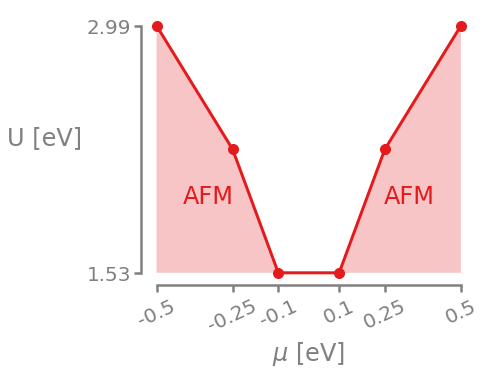

In [15]:
fig = plt.figure()

ax_pd = fig.add_subplot(111)

ax_pd.plot(mus, U_cs, "o", ls="-")
ax_pd.fill_between(mus,[min(U_cs)]*len(U_cs),U_cs, alpha=0.25)

ax_pd.set_ylabel('U [eV]', rotation=0, ha='right')
ax_pd.set_xlabel('$\mu$ [eV]')

ax_pd.set_yticks([min(U_cs), max(U_cs)])
ax_pd.set_xticks(mus)
ax_pd.set_xticklabels(mus, rotation=25)

ax_pd.spines['left'].set_bounds(min(U_cs), max(U_cs))
ax_pd.spines['bottom'].set_bounds(min(mus), max(mus))


ax_pd.text(0.725, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')
ax_pd.text(0.125, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')

Here we see that the AFM phase is indeed symmetric for $\mu=0$.

If we now introduce a next-nearest neighbor hopping we introduce hopping between sublattices of the same type.
The kinetic term of the Hubbard model does then contain terms of the form $c_{1 \sigma}^{\dagger} c_{l \sigma}$, which are not invariant under PHT

$$
c_{l \sigma}^{\dagger} c_{l \sigma} \longrightarrow \underbrace{(-1)^{2l}}_{=1} d_{l \sigma} d_{l \sigma}^{\dagger}=
d_{l \sigma} d_{l \sigma}^{\dagger}= -d_{l \sigma}^{\dagger} d_{l \sigma}\,.
$$

Such a model is therefore not symmetric for $\mu=0$, which we can test.

In [16]:
hubbard_next_nearest_neighbor_hopping = hubbard.copy(tp=-0.05)

e_k = get_disperion_relation(hubbard_next_nearest_neighbor_hopping)

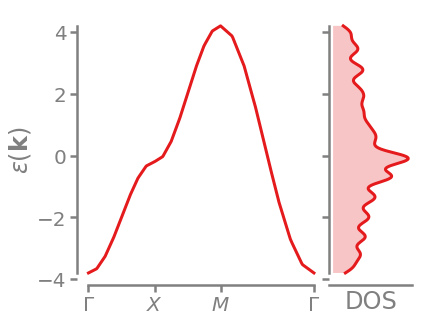

In [17]:
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from plotting_tools import bsplot

fig = plt.figure()

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
gs.update(wspace=0.025, hspace=0.05)

# -- Bandstructure
ax_bs = plt.subplot(gs[0])

lower_limit = np.min(e_k.data.real)
upper_limit = np.max(e_k.data.real)

path = 'G-X-M-G'
ax_bs.bsplot(e_k, path)

ax_bs.spines['left'].set_bounds(lower_limit, upper_limit)
ax_bs.spines['bottom'].set_bounds(ax_bs.get_xticks()[0], ax_bs.get_xticks()[-1])

ax_bs.set_ylabel('$\epsilon(\mathbf{k})$')
# -- Density of states
ax_dos = plt.subplot(gs[1])

dos = gaussian_kde(e_k.data[:,0,0].real)
xs = np.linspace(lower_limit, upper_limit , 500)
dos.covariance_factor = lambda : .1
dos._compute_covariance()

ax_dos.plot(dos(xs).real, xs)
ax_dos.fill_betweenx(xs, dos(xs).real, [0]*len(xs), alpha=0.25)
#ax_dos.set_xlim()

#ax_dos.spines['left'].set_visible(False)
ax_dos.set_xlabel('DOS')

ax_dos.set_yticklabels([''])
ax_dos.set_xticks([])

ax_dos.spines['left'].set_bounds(lower_limit, upper_limit)


In [18]:
%%capture

mus = [-.5, -.25, -0.1, 0.1, .25, .5]

hubbard_models = parameter_scan(hubbard_next_nearest_neighbor_hopping, mu=mus)

U_cs = []

for hubbard_model in hubbard_models:
        
    U_c = get_spin_phase_transistion(hubbard_model)   
    U_cs.append(U_c)

Text(0.125,0.1,'AFM')

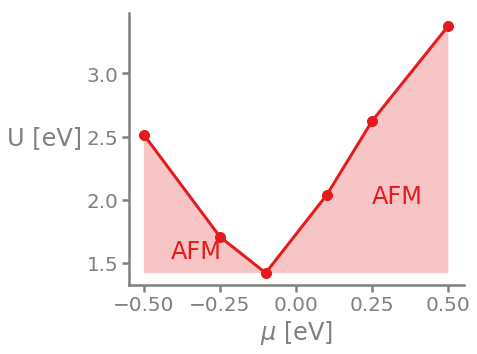

In [19]:
fig = plt.figure()

ax_pd = fig.add_subplot(111)

ax_pd.plot(mus, U_cs, "o", ls="-")
ax_pd.fill_between(mus,[min(U_cs)]*len(U_cs),U_cs, alpha=0.25)

ax_pd.set_ylabel('U [eV]', rotation=0, ha='right')
ax_pd.set_xlabel('$\mu$ [eV]')

ax_pd.text(0.725, 0.3, "AFM", transform = ax_pd.transAxes, size=24, color='C0')
ax_pd.text(0.125, 0.1, "AFM", transform = ax_pd.transAxes, size=24, color='C0')

## Semi particle-hole transformation

If we use the PHT only on one spin specices it is called a semi particle-hole transformation (SPHT).
This means

$$
c_{j \uparrow}^{\dagger} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}^{\dagger}\quad\mathrm{and}\quad
c_{j \uparrow} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}\\
c_{j \downarrow}^{\dagger} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}\quad\mathrm{and}\quad
c_{j \downarrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}^{\dagger}\,.
$$

Lets remember the Hubbard Hamiltonian that is invariant under a PHT

$$
H=-t \sum_{\langle j, l\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{l \sigma}+c_{l \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j}\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right)-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)\,.
$$

The kinetic term only consist of operators with the same spin and is therefore invariant under SPHT as it was under PHT.
The interaction term on the underhand has to be treated with more care

$$
\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right) \xrightarrow{\mathrm{SPHT}}
\left(\tilde{n}_{j \uparrow}-\frac{1}{2}\right)\left(1-\tilde{n}_{j \downarrow}-\frac{1}{2}\right) = 
\left(\tilde{n}_{j \uparrow} - \frac{1}{2}\right)\left(\frac{1}{2}-\tilde{n}_{j \downarrow}\right) = \\
-\left(\tilde{n}_{j \uparrow} - \frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)\,.
$$

Under a SPHT we map the repulsive Hubbard model with $U$ to the attractive one with $-U$.
The chemical potential term is also not invariant under a SPHT

$$
n_{j \uparrow}+n_{j \downarrow} \xrightarrow{\mathrm{SPHT}}
\tilde{n}_{j \uparrow}+1-\tilde{n}_{j \downarrow} = 
1 + \left(\tilde{n}_{j \uparrow}-\tilde{n}_{j \downarrow}\right)\,,
$$

and transforms into a Zeeman term.

To summarize the SPHT maps the Hubbard Hamiltonian with interaction strength $U$ and chemical potential $\mu$ to a Hubbard Hamiltonian with interaction strength $-U$, a chemical potential of $0$ and an additional Zeeman term of strength $\mu$.

Lets start again with the spin operator in $z$-direction,

$$
S^z_j = n_{j \uparrow} - n_{j \downarrow} \xrightarrow{\mathrm{SPHT}} \tilde{n}_{j \uparrow} - (1 - \tilde{n}_{j \downarrow}) = -1 + \tilde{n}_{j \uparrow} + \tilde{n}_{j \downarrow}\,.
$$

which is just the density operator 

$$
\tilde{n}_{j}= \tilde{n}_{j \uparrow} + \tilde{n}_{j \downarrow}
$$

with a constant.
If one calculates a susceptibility one is only interested in the change of the expectation value of an obserable $A$ when going from an unperturbed system to one which is perturbed by a field coupling to operator $B$.
Therefore a constant factor in an observable is unimportant when calculating susceptibilites.

If we consider a Hubbard model at half-filling, i.e. $\mu=0.0$ the $T-U$ phase diagram is symmetric for $U=0$



In [20]:
def get_charge_phase_transistion(p):
    """Return U at which model p transitions to charge order via root search
    """
    p.copy()

    chi0_wk = get_chi0(p)
    
    def one_over_charge(U):
        
        p.U = U
        chi_c_wk, _ = get_chiRPA(p, chi0_wk)
        
        # -- If any value is below zero we are already in an ordered phase
        if np.any(chi_c_wk.data[np.abs(chi_c_wk.data) > 1e-3] < 0.0 ):
            return -1
        
        chi_at_critical_k = np.max(chi_c_wk.data)
        return 1./chi_at_critical_k
    
    U_c = brentq(one_over_charge, -10, 0.0)
    
    return U_c

In [21]:
%%capture

Ts = [1000, 750, 500, 250]
hubbard_models = parameter_scan(hubbard, T=Ts)

U_spin_cs = []
U_charge_cs = []

for hubbard_model in hubbard_models:
    
    U_spin_c = get_spin_phase_transistion(hubbard_model)
    U_charge_c = get_charge_phase_transistion(hubbard_model)   

    U_spin_cs.append(U_spin_c)
    U_charge_cs.append(U_charge_c)

Text(0.07,0.15,'CDW')

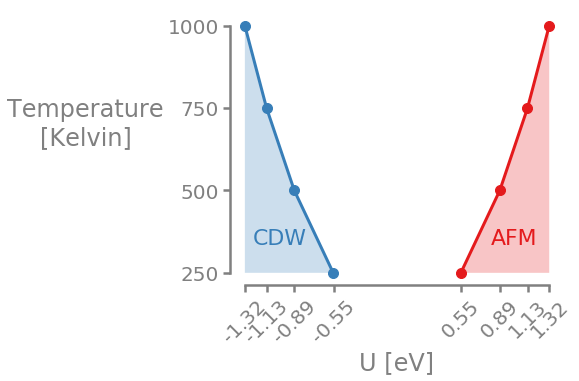

In [22]:
fig = plt.figure()

ax_pd = fig.add_subplot(111)

ax_pd.plot(U_spin_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_spin_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)

ax_pd.plot(U_charge_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_charge_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)


ax_pd.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd.set_xlabel('U [eV]')

ax_pd.set_yticks(Ts)
ax_pd.set_xticks([np.round(ele,2) for ele in U_spin_cs+U_charge_cs])
ax_pd.set_xticklabels([np.round(ele,2) for ele in U_spin_cs+U_charge_cs], rotation=45)

ax_pd.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd.spines['bottom'].set_bounds(min(ax_pd.get_xticks()), max(ax_pd.get_xticks()))

ax_pd.text(0.78, 0.15, "AFM", transform = ax_pd.transAxes, size=22, color='C0')
ax_pd.text(0.07, 0.15, "CDW", transform = ax_pd.transAxes, size=22, color='C1')

The SPHT also gives information about the superconducting phase of the attractive Hubbard model, this can be seen by transforming the ladder operators of the spin

$$
S^+_j = S^x_j + iS^y_j = c_{j \uparrow}^{\dagger}c_{j \downarrow} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}^{\dagger}d_{j \downarrow}^{\dagger} = \tilde{\Delta}^{\dagger}\,,\\
S^-_j = S^x_j - iS^y_j = c_{j \downarrow}^{\dagger}c_{j \uparrow} \xrightarrow{\mathrm{SPHT}} d_{j \downarrow}d_{j \uparrow} = \tilde{\Delta}\,.
$$

The x- and y-components of the spin operator are transformed to the complex superconducting oder parameter.
We wil focus on $S^x$, because even if we apply a Zeeman term the x- and y-components will be degenerate.
This means, that if we find a diverging $\langle S^xS^x \rangle$ in the repulsive model at some $U$ we will see a superconducting phase at $-U$.

To calculate $\langle S^xS^x \rangle$ we need the spin dependent general susceptibility tensor.
We can obtain this from $\chi^{(c)}$ and $\chi^{(s)}$ if our system is $\mathrm{SU(2)}$ symmetric.
This can be done via the `general_susceptibility_from_charge_and_spin` function from the module `triqs_tprf.rpa_tensor`.

In [23]:
from triqs_tprf.rpa_tensor import general_susceptibility_from_charge_and_spin

chi_c_wk, chi_s_wk  = get_chiRPA(hubbard)

chi_rpa_general_wk = general_susceptibility_from_charge_and_spin(chi_c_wk, chi_s_wk)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 11.6045250062
nk    = 256
nw    = 100
norb  = 1

Approx. Memory Utilization: 0.00 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


We can then use the matrix representation of $S^x$ to do the contraction.

In [24]:
S_x = 0.5 * np.array([[0,1], [1,0]])

def chi_contraction(chi, op1, op2):
    chi_op1op2 = chi[:1,:1,:1,:1].copy()
    chi_op1op2.data[:,:,0,0,0,0] = np.einsum('wqabcd,ab,cd->wq', chi.data, op1, op2)
    return chi_op1op2

chi_sxsx = chi_contraction(chi_rpa_general_wk, S_x, S_x)

But for a $\mathrm{SU(2)}$ symmetric system doing this is unnecessary, because

$$
\langle S^z S^z \rangle = \langle S^x S^x \rangle\,,
$$

and we therefore already know where the superconducting phase in the attractive model lies, it is degenerate with the CDW.

We will now use the implementation of the linearized Eliashberg equation to confirm this superconducting phase.
To do this we will construct the pairing vertex $\Gamma$ in the singlet channel via the spin- and charge susceptibilites by using the `gamma_PP_singlet` function of the `triqs_tprf.lattice` module.
We can then use the `solve_eliashberg` function of the `triqs_tprf.eliashberg` module to solve the linearized eliashberg equation for the specifc $\Gamma$ to obtain the $\lambda$ as an indicator for the strength of the superconducting phase.
If

$$
\lambda = 1
$$

we encounter a phase transition to the superconducting phase.
To find this phase transition we use the same procedure as for the susceptibilites and search when

$$
\lambda - 1 \approx 0\,.
$$

In [25]:
from triqs_tprf.lattice import gamma_PP_singlet
from triqs_tprf.eliashberg import solve_eliashberg

def get_lambda_delta(p):
    """Solve the linearized eliashberg equation for model parameters in a ParameterCollection
    """

    e_k = get_disperion_relation(p)

    wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
    g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
    
    chi0_wk = imtime_bubble_chi0_wk(g0_wk, nw=p.nw)

    U_c, U_s = kanamori_charge_and_spin_quartic_interaction_tensors(p.norb, p.U, 0.0, 0.0, 0.0)

    chi_c_wk = solve_rpa_PH(chi0_wk, -U_c)
    chi_s_wk = solve_rpa_PH(chi0_wk, U_s)

    gamma_singlet_wk = gamma_PP_singlet(chi_c_wk, chi_s_wk, U_c, U_s)

    Es, eigen_modes = solve_eliashberg(gamma_singlet_wk, g0_wk,
                                       solver='IRAM', tol=1e-5)

    return Es[0], eigen_modes[0]

def get_sc_phase_transistion(p, guess=None):
    """Return U at which model p transitions to superconducting order via root search
    """
    
    e_k = get_disperion_relation(p)

    wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
    g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
    
    chi0_wk = imtime_bubble_chi0_wk(g0_wk, nw=p.nw)
    
    def lambda_minus_1(U):

        U_c, U_s = kanamori_charge_and_spin_quartic_interaction_tensors(p.norb, U, 0.0, 0.0, 0.0)
        
        chi_c_wk = solve_rpa_PH(chi0_wk, -U_c)
        chi_s_wk = solve_rpa_PH(chi0_wk, U_s)

        gamma_singlet_wk = gamma_PP_singlet(chi_c_wk, chi_s_wk, U_c, U_s)

        Es, eigen_modes = solve_eliashberg(gamma_singlet_wk, g0_wk,
                                           solver='IRAM', tol=1e-5)
        lamb = max(Es)
        
        print(lamb, U)
        
        return lamb - 1.0
    
    upper = guess
    lower = 0.5*guess
    
    U_c = brentq(lambda_minus_1, lower, upper, xtol=1e-4)

    return U_c

In [26]:
%%capture

Ts = [1000, 750, 500, 250]
hubbard_models = parameter_scan(hubbard, T=Ts)
guesses = [-ele for ele in U_spin_cs]

U_sc_cs = []

for hubbard_model, guess in zip(hubbard_models, guesses):
    
    U_sc_c = get_sc_phase_transistion(hubbard_model, guess)

    U_sc_cs.append(U_sc_c)


Text(0.07,0.15,'SC')

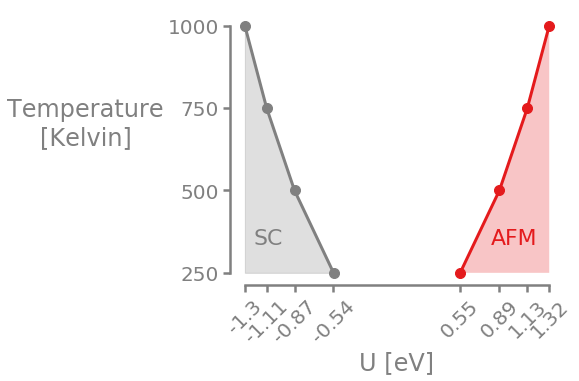

In [27]:
fig = plt.figure()

ax_pd = fig.add_subplot(111)

ax_pd.plot(U_spin_cs, Ts, "o", ls="-")
ax_pd.fill_between(U_spin_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25)

ax_pd.plot(U_sc_cs, Ts, "o", ls="-", color='grey')
ax_pd.fill_between(U_sc_cs, Ts, [Ts[-1]]*len(Ts), alpha=0.25, color='grey')


ax_pd.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd.set_xlabel('U [eV]')

ax_pd.set_yticks(Ts)
ax_pd.set_xticks([np.round(ele,2) for ele in U_spin_cs+U_sc_cs])
ax_pd.set_xticklabels([np.round(ele,2) for ele in U_spin_cs+U_sc_cs], rotation=45)

ax_pd.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd.spines['bottom'].set_bounds(min(ax_pd.get_xticks()), max(ax_pd.get_xticks()))

ax_pd.text(0.78, 0.15, "AFM", transform = ax_pd.transAxes, size=22, color='C0')
ax_pd.text(0.07, 0.15, "SC", transform = ax_pd.transAxes, size=22, color='grey')

The superconducting phase gets correctly predicted by the linearized Eliashberg equation.

## Not at half-filling

If we are not at half-filling in the repulsive Hubbard model we have to take the Zeeman term into account in the attractive model.
Because the implementation of the linearized Eliashberg equation is right now limited to $\mathrm{SU(2)}$ symmetric systems and the Zeeman term breaks this symmetry we will apply the Zeeman term in the repulsive model.
This means, that 

$$
\langle S^z S^z \rangle \neq \langle S^x S^x \rangle\,,
$$

and the CDW will therefore no longer be degenerate with the superconducting phase.

To add the Zeeman term in the repulsive model we will introduce a new function for the disperison relation and use a Hubbard model with explicitly carries spin as an index, i.e. two orbitals instead of one.

In [28]:
def get_disperion_relation_spin_dependent(p):
    """Return the disperion relation for model parameters in a ParameterCollection
    """
    
    try:
        zeeman = p.zeeman * np.array([[1,0], [0,-1]])
    except AttributeError:
        zeeman = 0.0 * np.array([[1,0], [0,-1]])
        
    t = -p.t * np.eye(p.norb)
    
    # next-nearest neighbour hopping only if p has `tp` attribute
    try:
        tp = -p.tp * np.eye(p.norb)
    except AttributeError:
        tp = 0 * np.eye(p.norb)
    
    H = TBLattice(
        units = [(1, 0, 0), (0, 1, 0)],
        hopping = {
            # Zeeman term
            ( 0, 0): zeeman,
            
            # nearest neighbour hopping
            ( 0,+1): t,
            ( 0,-1): t,
            (+1, 0): t,
            (-1, 0): t,
            
            # next-nearest neighbour hopping
            ( +1,+1): tp,
            ( -1,-1): tp,
            (+1, -1): tp,
            (-1, +1): tp,
            },
        orbital_positions = [(0,0,0)]*p.norb,
        )
    
    e_k = H.on_mesh_brillouin_zone(n_k = (p.nk, p.nk, 1))

    return e_k

hubbard_spin_dependent = hubbard.copy(norb=2)

e_k = get_disperion_relation_spin_dependent(hubbard_spin_dependent.copy(zeeman=1.0))

Text(0.54,0.65,'$\\downarrow$')

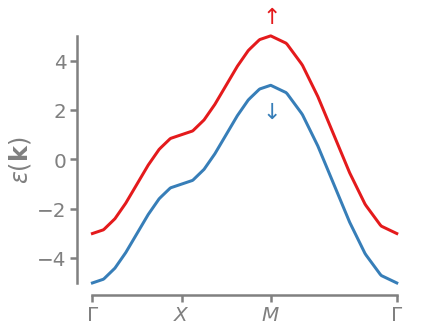

In [29]:
fig = plt.figure()

# -- Bandstructure
ax_bs = fig.add_subplot(111)

lower_limit = np.min(e_k.data.real)
upper_limit = np.max(e_k.data.real)

path = 'G-X-M-G'

ax_bs.bsplot(e_k[:1,:1], path)
ax_bs.bsplot(e_k[1:2,1:2], path)

ax_bs.spines['left'].set_bounds(lower_limit, upper_limit)
ax_bs.spines['bottom'].set_bounds(ax_bs.get_xticks()[0], ax_bs.get_xticks()[-1])

ax_bs.set_ylabel('$\epsilon(\mathbf{k})$')

ax_bs.text(0.54, 1., "$\uparrow$", transform = ax_bs.transAxes, size=22, color='C0')
ax_bs.text(0.54, 0.65, "$\downarrow$", transform = ax_bs.transAxes, size=22, color='C1')

We will introduce versions of the functions we defined before, i.e. `get_chi0`, `get_chiRPA`, as a spin dependent version.
Also we introduce the function `get_sus` to get the interacting susceptibility for any two operators and `get_phase_transition` to find the phase transition for any order defined by any two operators.

In [30]:
def get_chi0_spin_dependent(p, e_k=None):
    """Return the non-interaction susceptibility for model parameters in a ParameterCollection
    """
    
    if not e_k:
        e_k = get_disperion_relation_spin_dependent(p)

    wmesh = MeshImFreq(beta=temperature_to_beta(p.T), S='Fermion', n_max=p.nw)
    g0_wk = lattice_dyson_g0_wk(mu=p.mu, e_k=e_k, mesh=wmesh)
    
    chi0_wk = imtime_bubble_chi0_wk(g0_wk, nw=p.nw)
        
    return chi0_wk

from triqs_tprf.rpa_tensor import quartic_tensor_from_charge_and_spin

def get_chiRPA_spin_dependent(p, chi0_wk=None):
    
    if not chi0_wk:
        chi0_wk = get_chi0_spin_dependent(p)
        
    U_c, U_s = kanamori_charge_and_spin_quartic_interaction_tensors(1, p.U, 0.0, 0.0, 0.0)
    U_abcd = quartic_tensor_from_charge_and_spin(U_c, U_s)
        
    chi_rpa_wk = solve_rpa_PH(chi0_wk, U_abcd)
    
    return chi_rpa_wk

def get_sus(p, op1, op2, chi0_wk=None):
    
    chi_rpa_wk = get_chiRPA_spin_dependent(p, chi0_wk)
    chi_op1op2 = chi_contraction(chi_rpa_wk, op1, op2)
    
    return chi_op1op2

def get_phase_transition(p, op1, op2, lower=0.0, upper=10):
    """Return U at which model p transitions to any order of op1 and op2 via root search
    """
    # Make copy
    p = p.copy()
    
    chi0_wk = get_chi0_spin_dependent(p)
    
    def one_over_chi(U):
        
        p.U = U
        chi = get_sus(p, op1, op2, chi0_wk)
        
        # -- If any value is below zero we are already in an ordered phase
        if np.any(chi.data[np.abs(chi.data) > 1e-3] < 0.0 ):
            return -1
        
        chi_at_critical_k = np.max(chi.data)
        
        return 1./chi_at_critical_k
    
    U_c = brentq(one_over_chi, lower, upper)
    
    return U_c

We can then scan the phase space of the repulsive Hubbard model with a Zeeman term of strength $\xi$ and an attractive model which is doped by $\mu=\xi$.
And as we know the AFM and CDW phases should be symmetric for $U=0.$

In [31]:
%%capture

# Density operator
n = np.eye(2)
# Spin operator
S_z = 0.5 * np.array([[1,0], [0,-1]])


xi = 0.1

Ts = [1000, 750, 500]
hubbard_models_doped = parameter_scan(hubbard_spin_dependent.copy(mu=xi), T=Ts)
hubbard_models_zeeman = parameter_scan(hubbard_spin_dependent.copy(zeeman=xi), T=Ts)

U_spin_cs = []
U_charge_cs = []

for hubbard_model_doped, hubbard_model_zeeman in zip(hubbard_models_doped, hubbard_models_zeeman):
    
    U_spin_c = get_phase_transition(hubbard_model_zeeman, S_z, S_z, 0, 10)
    U_charge_c = get_phase_transition(hubbard_model_doped, n, n, -10, 0)   

    U_spin_cs.append(U_spin_c)
    U_charge_cs.append(U_charge_c)

Text(0.4,0.5,'AFM')

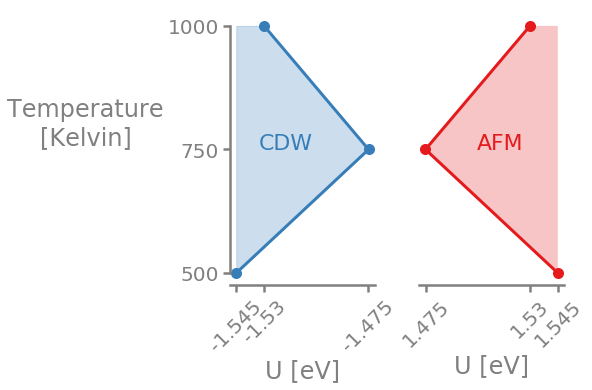

In [32]:
fig = plt.figure()

ax_pd_spin = fig.add_subplot(122)

ax_pd_spin.plot(U_spin_cs, Ts, "o", ls="-")
ax_pd_spin.fill_betweenx(Ts, U_spin_cs, [max(U_spin_cs)]*len(U_spin_cs) , alpha=0.25)

ax_pd_charge = fig.add_subplot(121)


ax_pd_charge.plot(U_charge_cs, Ts, "o", ls="-", color='C1')
ax_pd_charge.fill_betweenx(Ts, U_charge_cs, [min(U_charge_cs)]*len(U_charge_cs), alpha=0.25, color='C1')


ax_pd_charge.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd_charge.set_xlabel('U [eV]')
ax_pd_spin.set_xlabel('U [eV]')

ax_pd_charge.set_yticks(Ts)
ax_pd_spin.set_yticks([])

ax_pd_charge.set_xticks([np.round(ele,3) for ele in U_charge_cs])
ax_pd_charge.set_xticklabels([np.round(ele,3) for ele in U_charge_cs], rotation=45)
ax_pd_spin.set_xticks([np.round(ele,3) for ele in U_spin_cs])
ax_pd_spin.set_xticklabels([np.round(ele,3) for ele in U_spin_cs], rotation=45)

ax_pd_charge.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd_spin.spines['left'].set_visible(False)

ax_pd_charge.text(0.2, 0.5, "CDW", transform = ax_pd_charge.transAxes, size=22, color='C1')
ax_pd_spin.text(0.4, 0.5, "AFM", transform = ax_pd_spin.transAxes, size=22, color='C0')

In [33]:
%%capture

xi = 0.1

Ts = [1000, 750, 500]
hubbard_models_doped = parameter_scan(hubbard.copy(mu=xi), T=Ts)
hubbard_models_zeeman = parameter_scan(hubbard_spin_dependent.copy(zeeman=xi), T=Ts)

U_sx_cs = []
U_sc_cs = []

for hubbard_model_doped, hubbard_model_zeeman in zip(hubbard_models_doped, hubbard_models_zeeman):
    
    U_sx_c = get_phase_transition(hubbard_model_zeeman, S_x, S_x)
    U_sc_c = get_sc_phase_transistion(hubbard_model_doped, guess=-1.2*U_sx_c)   

    U_sx_cs.append(U_sx_c)
    U_sc_cs.append(U_sc_c)

Text(0.6,0.35,'prediction')

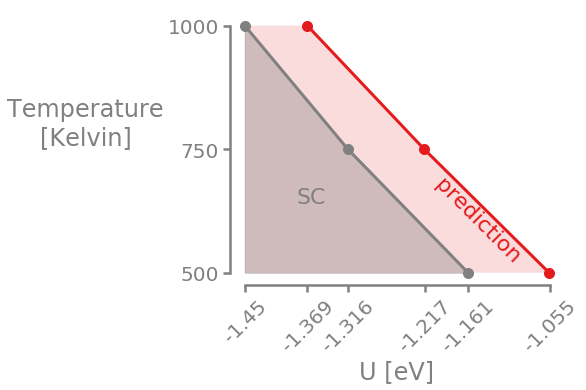

In [34]:
fig = plt.figure()

ax_pd_sc = fig.add_subplot(111)

negative_U_sx_cs = [-ele for ele in U_sx_cs]

ax_pd_sc.plot(negative_U_sx_cs, Ts, "o", ls="-")
ax_pd_sc.fill_betweenx(Ts, negative_U_sx_cs, [min(U_sc_cs)]*len(negative_U_sx_cs) , alpha=0.15)

ax_pd_sc.plot(U_sc_cs, Ts, "o", ls="-", color='grey')
ax_pd_sc.fill_betweenx(Ts, U_sc_cs, [min(U_sc_cs)]*len(U_sc_cs), alpha=0.35, color='grey')

ax_pd_sc.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd_sc.set_xlabel('U [eV]')

ax_pd_sc.set_yticks(Ts)

ax_pd_sc.set_xticks([np.round(ele,3) for ele in U_sc_cs+negative_U_sx_cs])
ax_pd_sc.set_xticklabels([np.round(ele,3) for ele in U_sc_cs+negative_U_sx_cs], rotation=45)

ax_pd_sc.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd_sc.spines['bottom'].set_bounds(min(ax_pd_sc.get_xticks()), max(ax_pd_sc.get_xticks()))


ax_pd_sc.text(0.2, 0.3, "SC", transform = ax_pd_sc.transAxes, size=22, color='Grey')
ax_pd_sc.text(0.6, 0.35, "prediction", transform = ax_pd_sc.transAxes, size=22, color='C0', rotation=-45)



╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 11.6045250062
nk    = 256
nw    = 100
norb  = 1

Approx. Memory Utilization: 0.00 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


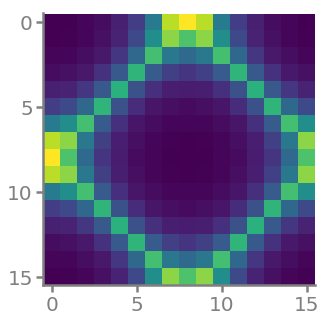

In [35]:
_, delta_1 = get_lambda_delta(hubbard.copy(mu=xi, U=U_sc_cs[0]))

plt.imshow(delta_1[Idx(0), :].data.reshape(hubbard.nk, hubbard.nk).real)

In [36]:
%%capture

xi = 0.3

Ts = [1000, 750, 500]
hubbard_models_doped = parameter_scan(hubbard.copy(mu=xi), T=Ts)
hubbard_models_zeeman = parameter_scan(hubbard_spin_dependent.copy(zeeman=xi), T=Ts)

U_sx_cs = []
U_sc_cs = []

for hubbard_model_doped, hubbard_model_zeeman in zip(hubbard_models_doped, hubbard_models_zeeman):
    
    U_sx_c = get_phase_transition(hubbard_model_zeeman, S_x, S_x)
    U_sc_c = get_sc_phase_transistion(hubbard_model_doped, guess=-1.2*U_sx_c)   

    U_sx_cs.append(U_sx_c)
    U_sc_cs.append(U_sc_c)

Text(0.6,0.35,'prediction')

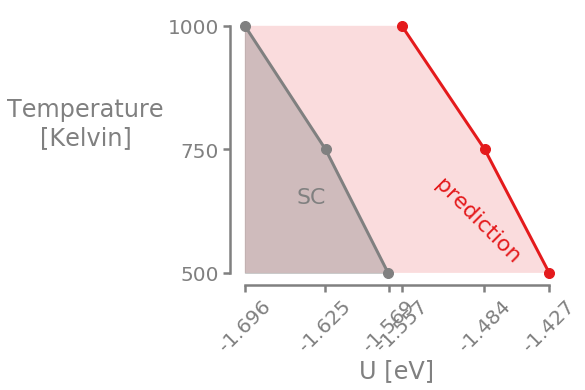

In [37]:
fig = plt.figure()

ax_pd_sc = fig.add_subplot(111)

negative_U_sx_cs = [-ele for ele in U_sx_cs]

ax_pd_sc.plot(negative_U_sx_cs, Ts, "o", ls="-")
ax_pd_sc.fill_betweenx(Ts, negative_U_sx_cs, [min(U_sc_cs)]*len(negative_U_sx_cs) , alpha=0.15)

ax_pd_sc.plot(U_sc_cs, Ts, "o", ls="-", color='grey')
ax_pd_sc.fill_betweenx(Ts, U_sc_cs, [min(U_sc_cs)]*len(U_sc_cs), alpha=0.35, color='grey')

ax_pd_sc.set_ylabel('Temperature\n[Kelvin]', rotation=0, ha='right', multialignment='center')
ax_pd_sc.set_xlabel('U [eV]')

ax_pd_sc.set_yticks(Ts)

ax_pd_sc.set_xticks([np.round(ele,3) for ele in U_sc_cs+negative_U_sx_cs])
ax_pd_sc.set_xticklabels([np.round(ele,3) for ele in U_sc_cs+negative_U_sx_cs], rotation=45)

ax_pd_sc.spines['left'].set_bounds(Ts[-1], Ts[0])
ax_pd_sc.spines['bottom'].set_bounds(min(ax_pd_sc.get_xticks()), max(ax_pd_sc.get_xticks()))


ax_pd_sc.text(0.2, 0.3, "SC", transform = ax_pd_sc.transAxes, size=22, color='Grey')
ax_pd_sc.text(0.6, 0.35, "prediction", transform = ax_pd_sc.transAxes, size=22, color='C0', rotation=-45)



╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 11.6045250062
nk    = 256
nw    = 100
norb  = 1

Approx. Memory Utilization: 0.00 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_tr_from_grt_PH (bubble in tau & r)
--> chi_wr_from_chi_tr
--> chi_wk_from_chi_wr (r->k)


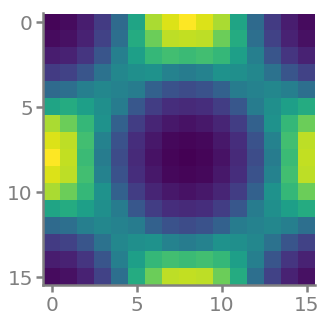

In [38]:
_, delta_1 = get_lambda_delta(hubbard.copy(mu=xi, U=U_sc_cs[0]))

plt.imshow(delta_1[Idx(0), :].data.reshape(hubbard.nk, hubbard.nk).real)